In [28]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Goal of this assignment:  
gaining hand-on experience of using some prediction algorithms learned in the class, and writing up the results in a report.

You will continue working on the data set you used in HW1, and your task is to predict the class variable LEAVE representing whether each customer decided to quit the company or not. The class variable, LEAVE, is the last variable on each line, and its legal values are LEAVE and STAY.

# Analysis 
Pick and apply at least two different predictive methods (of your choice) to predict whether the customers churned (STAY or LEAVE). You may need to convert the data to a format that is more compatible with the models you use, such as one-hot encoding, etc. Please include results of Decision Tree and KNN. 



In [29]:
df = pd.read_excel('Customer_Churn.xlsx')

df['COLLEGE'] = df['COLLEGE'].rank(method='dense',ascending=False).astype(int) -1

sat_map = {'very_unsat': 0, 
           'unsat': 1,
           'avg': 2,
           'sat': 3,
           'very_sat': 4}
df['REPORTED_SATISFACTION'] = df['REPORTED_SATISFACTION'].map(sat_map)

usg_map = {'very_little': 0, 
           'little': 1,
           'avg': 2,
           'high': 3,
           'very_high': 4}
df['REPORTED_USAGE_LEVEL'] = df['REPORTED_USAGE_LEVEL'].map(usg_map)

chng_map = {'never_thought': 0, 
           'no': 1,
           'perhaps': 2,
           'considering': 3,
           'actively_looking_into_it': 4}
df['CONSIDERING_CHANGE_OF_PLAN'] = df['CONSIDERING_CHANGE_OF_PLAN'].map(chng_map)

leave_map = {'LEAVE': True, 
           'STAY': False}
df['LEAVE'] = df['LEAVE'].map(leave_map)

df.head()





,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,LEAVE
0,0,31953,0,6,313378,161,0,4,1,1,1,False
1,1,36147,0,13,800586,244,0,6,1,1,3,False
2,1,27273,230,0,305049,201,16,15,1,0,2,False
3,0,120070,38,33,788235,780,3,2,1,4,3,True
4,1,29215,208,85,224784,241,21,1,0,1,0,False


In [30]:
countStays = (y==False).sum()
countLeaves = (y==True).sum()
print('There are {} customers who left and {} customers who stayed'.format(countLeaves,countStays))
print('A model that always prints "STAY" would achieve a baseline accuracy of {}%'.format(round((countStays/(countLeaves+countStays))*100,2)))

There are 9852 customers who left and 10148 customers who stayed
A model that always prints "STAY" would achieve a baseline accuracy of 50.74%


In [31]:
left = df[df['LEAVE'] == True]
stay = df[df['LEAVE'] == False]
countLeft = len(left)

subsampleStay = stay.sample(n=countLeft)
sampledDf = pd.concat([left,subsampleStay])
sampledDf = sampledDf.sample(frac=1)

x = sampledDf.drop(columns = ['LEAVE'])
y = sampledDf['LEAVE']


In [32]:
countStays = (y==False).sum()
countLeaves = (y==True).sum()
print('After resample, there are {} customers who left and {} customers who stayed'.format(countLeaves,countStays))
print('A model that always prints "STAY" would achieve a baseline accuracy of {}%'.format(round((countStays/(countLeaves+countStays))*100,2)))

After resample, there are 9852 customers who left and 9852 customers who stayed
A model that always prints "STAY" would achieve a baseline accuracy of 50.0%


In [43]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=42)

In [49]:
dtreeResults = []
for i in range(3,50,5):
    tree = DecisionTreeClassifier(max_depth=i,criterion='entropy')
    tree = tree.fit(xtrain, ytrain)
    scores = cross_val_score(tree,xtrain,ytrain, cv=10,scoring='accuracy')
    dtreeResults.append([i,scores.mean()])

    
dtreeResults = np.array(dtreeResults)
maxAccuracyIndex = np.argmax(dtreeResults[:, 1])
best_max_depth = int(dtreeResults[maxAccuracyIndex, 0])

best_tree = DecisionTreeClassifier(max_depth=best_max_depth, criterion='entropy')
best_tree = best_tree.fit(xtrain, ytrain)

predictionDtree = best_tree.predict(xtest)
accuracyDtree = accuracy_score(ytest, predictionDtree)
print('Decision Tree achieved a max accuracy of {}% on test data using a depth of {}.'.format(round(accuracyDtree*100,2), best_max_depth))

Decision Tree achieved a max accuracy of 69.58% on test data using a depth of 8.


In [82]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance

knnResults = []
for i in range(3,50,5):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn = knn.fit(xtrain,ytrain)
    scores = cross_val_score(knn,xtrain,ytrain, cv=10,scoring='accuracy')
    knnResults.append([i,scores.mean()])

knnResults = np.array(knnResults)
maxAccuracyIndex = np.argmax(knnResults[:,1])
best_param = int(knnResults[maxAccuracyIndex, 0])

best_knn = KNeighborsClassifier(n_neighbors=best_param)
best_knn = best_knn.fit(xtrain, ytrain)

predictionKNN = best_knn.predict(xtest)
accuracyKNN = round(accuracy_score(ytest, predictionKNN)*100,2)

featuresKNN = permutation_importance(best_knn,xtest,ytest).importances_mean
print('K Nearest Neighbors acheived a max accuracy of {}% on training data using {} neighbors with a 10 K-fold Cross Validation '.format(accuracyKNN,depthKNN))

K Nearest Neighbors acheived a max accuracy of 61.43% on training data using 43 neighbors with a 10 K-fold Cross Validation 


In [60]:
from sklearn.ensemble import RandomForestClassifier

rfResults = []
for i in range(100,400,100):
    rf = RandomForestClassifier(n_estimators=i)
    rf = rf.fit(xtrain,ytrain)
    scores = cross_val_score(rf,xtrain,ytrain, cv=10,scoring='accuracy')
    rfResults.append([i,scores.mean()])


rfResults = np.array(rfResults)
maxAccuracyIndex = np.argmax(rfResults[:,1])
best_param = int(rfResults[maxAccuracyIndex, 0])

best_rf = RandomForestClassifier(n_estimators=best_param)
best_rf = best_rf.fit(xtrain, ytrain)

predictionRF = best_rf.predict(xtest)
accuracyRF = round(accuracy_score(ytest, predictionRF)*100,2)
print('Random Forest Classifier acheived max accuracy of {}% on training data using {} estimators with a 10 K-fold Cross Validation '.format(accuracyRF,best_param))

Random Forest Classifier acheived max accuracy of 69.73% on training data using 300 estimators with a 10 K-fold Cross Validation 


In [65]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg = logreg.fit(xtrain,ytrain)

scoreLr = cross_val_score(logreg,xtest,ytest,cv=10,scoring='accuracy')

maxAccuracyLogReg = round(scoreLr.mean()*100,2)

print('Logistic Regression achieved a max accuracy of {}% with a 10 K-Fold Cross Validation'.format(maxAccuracyLogReg))

Logistic Regression achieved a max accuracy of 62.88% with a 10 K-Fold Cross Validation


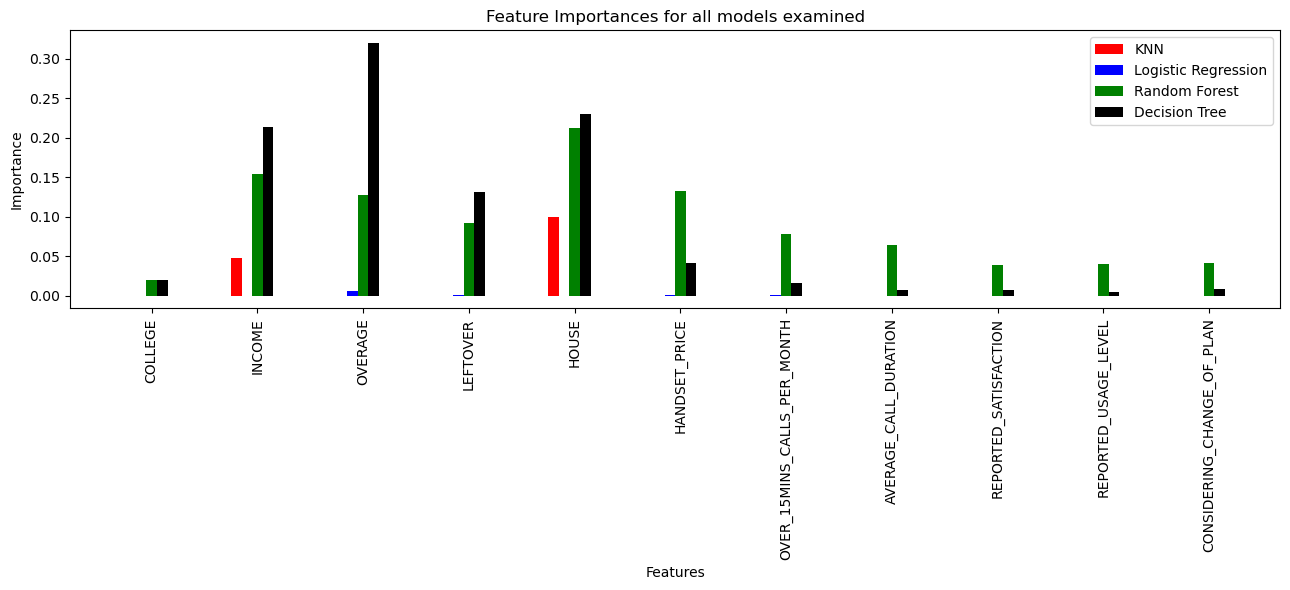

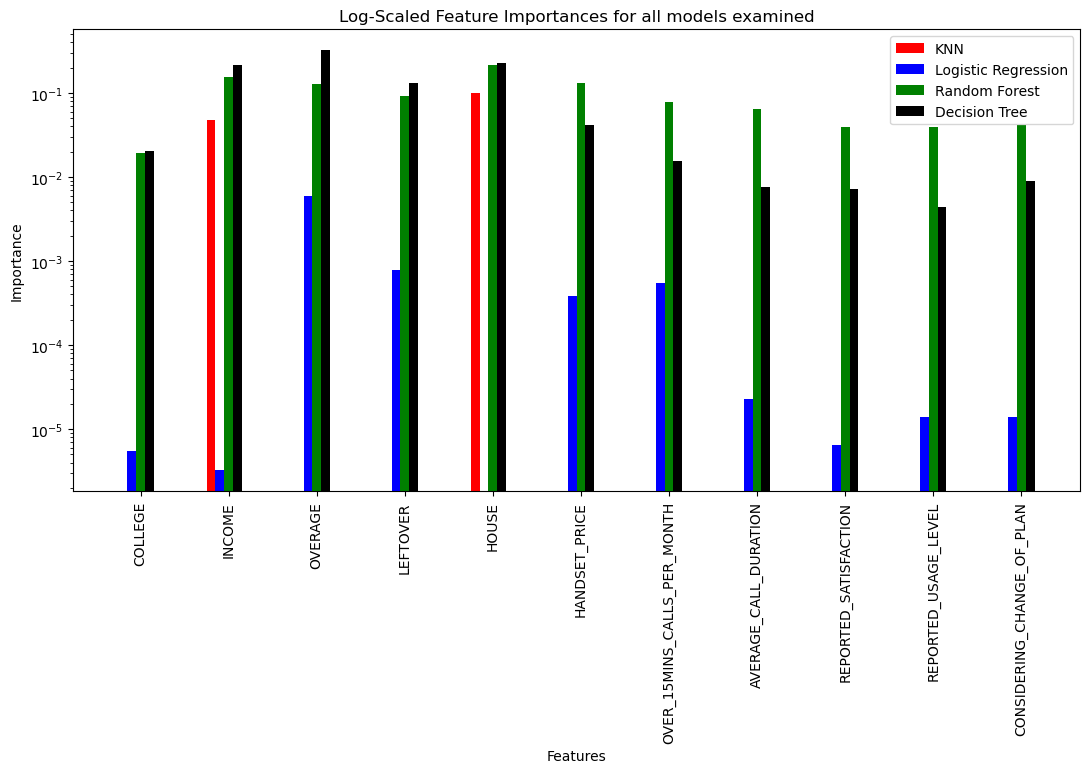

In [102]:
indices = np.arange(len(list(xtrain.columns)))

featureImportanceLog = logreg.coef_[0]
featureImportanceRF =  best_rf.feature_importances_
featureImportanceKNN =  featuresKNN
featureImportanceTree = best_tree.feature_importances_

bar_width = 0.1

# Create the figure
plt.figure(figsize=(13, 6))
#plt.yscale('log')

plt.bar(indices-bar_width, featureImportanceKNN, bar_width, label='KNN', color='red', align='center')
plt.bar(indices, featureImportanceLog, bar_width, label='Logistic Regression', color='blue', align='center')
plt.bar(indices + bar_width, featureImportanceRF, bar_width, label='Random Forest', color='green', align='center')
plt.bar(indices + 2*bar_width, featureImportanceTree, bar_width, label='Decision Tree', color='black', align='center')

# Set the x-axis labels
plt.xticks(indices + bar_width, featureNames, rotation=90)

# Set labels and title
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances for all models examined')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

plt.figure(figsize=(13, 6))
plt.yscale('log')
plt.bar(indices-bar_width, featureImportanceKNN, bar_width, label='KNN', color='red', align='center')
plt.bar(indices, featureImportanceLog, bar_width, label='Logistic Regression', color='blue', align='center')
plt.bar(indices + bar_width, featureImportanceRF, bar_width, label='Random Forest', color='green', align='center')
plt.bar(indices + 2*bar_width, featureImportanceTree, bar_width, label='Decision Tree', color='black', align='center')

# Set the x-axis labels
plt.xticks(indices + bar_width, featureNames, rotation=90)


# Set labels and title
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Log-Scaled Feature Importances for all models examined')
plt.legend()
plt.show()

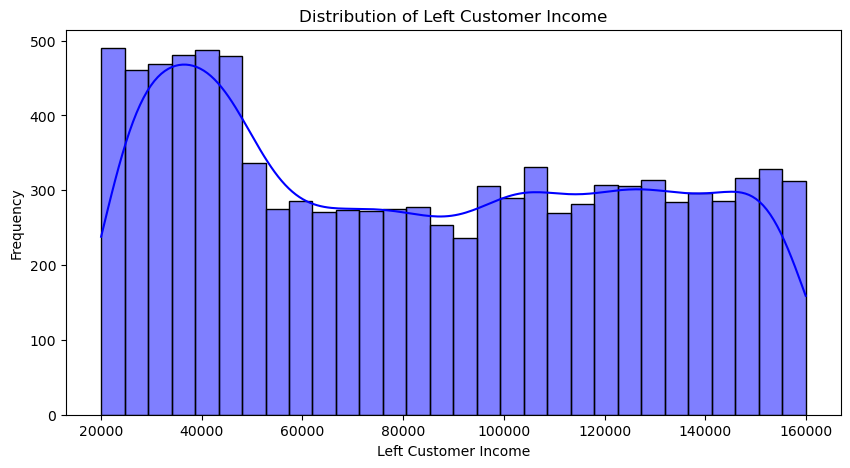

76325.85947970043 84355.88032886724
70119.5 81638.0
40344.118461429294 42633.83449763067 



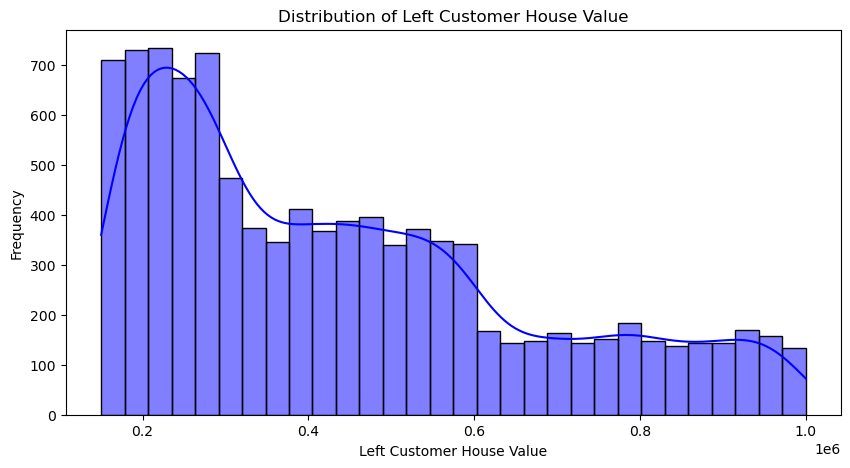

545682.4016554987 439049.9668087698 

547309.0 387481.0
263012.8876347474 228726.82737730385


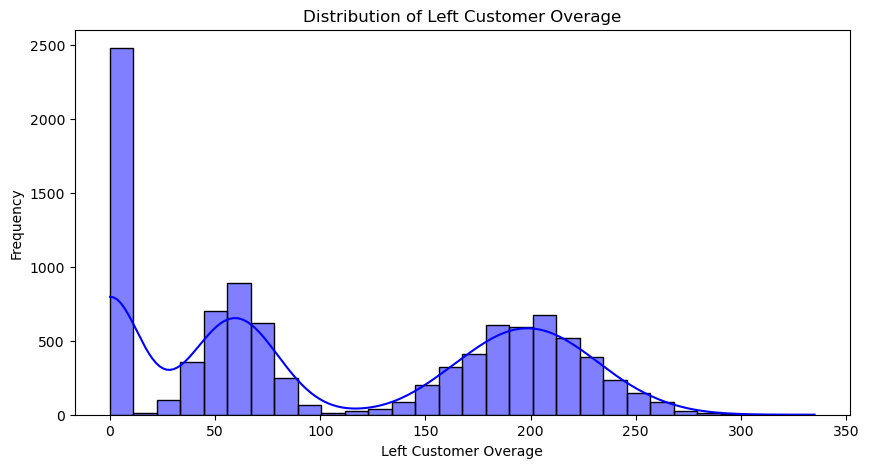

47.0 73.0
78.94439130914266 88.10667289168728
66.05695703586913 106.50071051563134 



In [137]:
left = df[df['LEAVE']==True]
stayed = df[df['LEAVE']==False]

#INCOME
plt.figure(figsize=(10, 5))
sns.histplot(left['INCOME'], kde=True, bins=30, color='blue')
plt.xlabel('Left Customer Income')
plt.ylabel('Frequency')
plt.title('Distribution of Left Customer Income')
plt.show()
print(stayed['INCOME'].mean(),left['INCOME'].mean())
print(stayed['INCOME'].median(),left['INCOME'].median())
print(stayed['INCOME'].std(),left['INCOME'].std(), '\n')

#HOUSE
plt.figure(figsize=(10, 5))
sns.histplot(left['HOUSE'], kde=True, bins=30, color='blue')
plt.xlabel('Left Customer House Value')
plt.ylabel('Frequency')
plt.title('Distribution of Left Customer House Value')
plt.show()

print(stayed['HOUSE'].mean(),left['HOUSE'].mean(),'\n')
print(stayed['HOUSE'].median(),left['HOUSE'].median())
print(stayed['HOUSE'].std(),left['HOUSE'].std())

#OVERAGE
plt.figure(figsize=(10, 5))
sns.histplot(left['OVERAGE'], kde=True, bins=30, color='blue')
plt.xlabel('Left Customer Overage')
plt.ylabel('Frequency')
plt.title('Distribution of Left Customer Overage')
plt.show()

print(stayed['OVERAGE'].median(),left['OVERAGE'].median())
print(stayed['OVERAGE'].std(),left['OVERAGE'].std())
print(stayed['OVERAGE'].mean(),left['OVERAGE'].mean(), '\n')

In [ ]:
left[